# pump probe analysis with femto second resolution of 

## importing libraries

In [1]:
import sys
import os
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from cycler import cycler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import interactive
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from scipy.interpolate import interp1d
from sklearn.decomposition import FastICA, PCA

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## setting graphing parameters

In [77]:
mpl.rcParams['figure.figsize'] = (16,8)

In [233]:
## notes from Lingjia's analysis

pump = 'THz'
##### Open data source and detector
ds = DataSource('exp=sxr72813:run='+str(runnum)+':smd')
acq1 = Detector('SxrEndstation.0:Acqiris.1')
acq0 = Detector('SxrEndstation.0:Acqiris.0')
evr = Detector('NoDetector.0:Evr.0')
gmd = Detector('GMD')
epics = ds.env().epicsStore()
gas = Detector('FEEGasDetEnergy')  # front end enclosure gas detectors
att = Detector('GATT:FEE1:310:R_ACT')    # attenuation factor
delay = Detector('LAS:FS2:Angle:Shift:Ramp:Target')
las = Detector('SXR:EXP:MMN:01:DLS')

## Loading data from h5 file

In [148]:
experiment_run_name = "sxr72813run65"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("hdf5/"+my_file,"r")

## converting to numpy array

In [208]:
fiducials  = array(my_hdf5_object['fiducials'])  
gmd        = array(my_hdf5_object['acq01']['ch1'])      #    gmd0 = acq0.waveform(evt)[0] 
apd        = array(my_hdf5_object['acq02']['ch2'])     #     apd = acq1.waveform(evt)[1]  
l3energy   = array(my_hdf5_object['ebeam']['L3_energy'])
delay_stage        = array(my_hdf5_object['delay_stage'])

## plotting some sample data

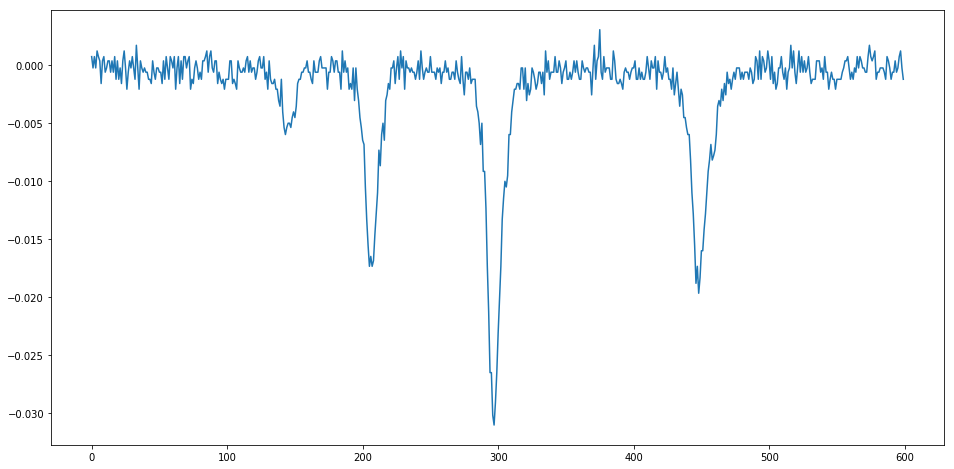

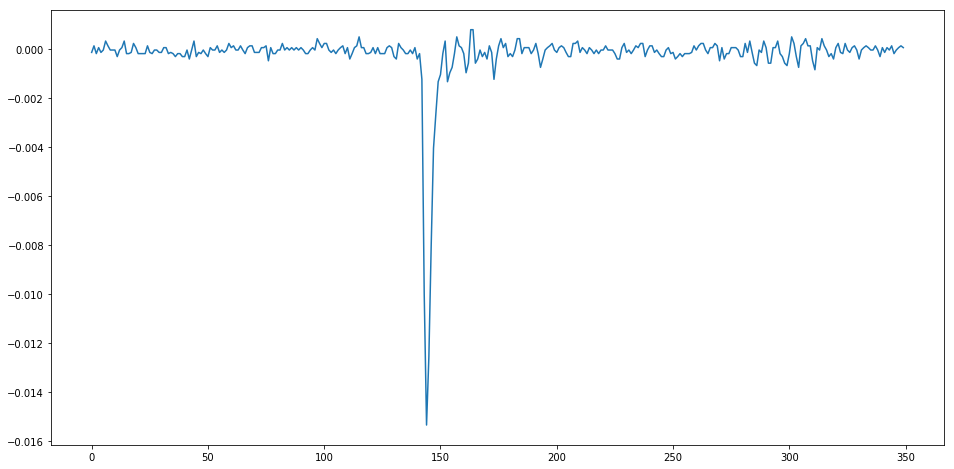

In [151]:
plot(gmd[3])
show()
plot(apd[3])
show()

## converting waveforms to single scalar photon flux

In [153]:
gmd_flux = sum(gmd**2,axis=1)**0.5
apd_flux = sum(apd[:,125:200]**2,axis=1)**0.5

## graphing results of scattered vs incident fluence

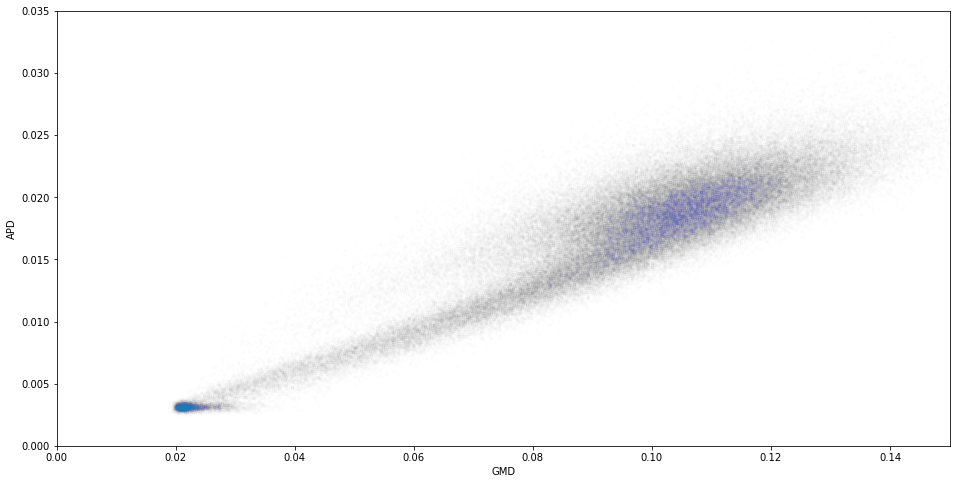

In [236]:
plot(gmd_flux,apd_flux,'.',alpha=0.002)
xlim(0,0.15)
ylim(0,0.035)
ylabel('APD')
xlabel('GMD')
show()

## defining mean centering function

In [157]:
def mean_centered(x):
    return x - mean(x)

## correcting for photon wavelength dependence

### defining X matrix for linear regression of X B = Y where B is the independent variables

In [158]:
X = array([ones(len(gmd_flux)),mean_centered(gmd_flux),mean_centered(l3energy),mean_centered(gmd_flux)*mean_centered(l3energy),mean_centered(gmd_flux)*mean_centered(l3energy)**2 ]).transpose()

In [159]:
X.shape

(141429, 5)

In [160]:
x_penrose = dot(inv(dot(X.transpose(),X)),X.transpose())

In [161]:
beta = dot(x_penrose,apd_flux)

In [162]:
beta

array([1.71205528e-02, 1.74882926e-01, 5.62400430e-04, 6.99402784e-03,
       1.46559688e-05])

In [163]:
X.shape

(141429, 5)

### applying correction to APD

In [164]:
apd_corrected = apd_flux - X[:,2]*beta[2]- X[:,3]*beta[3]-X[:,4]*beta[4]

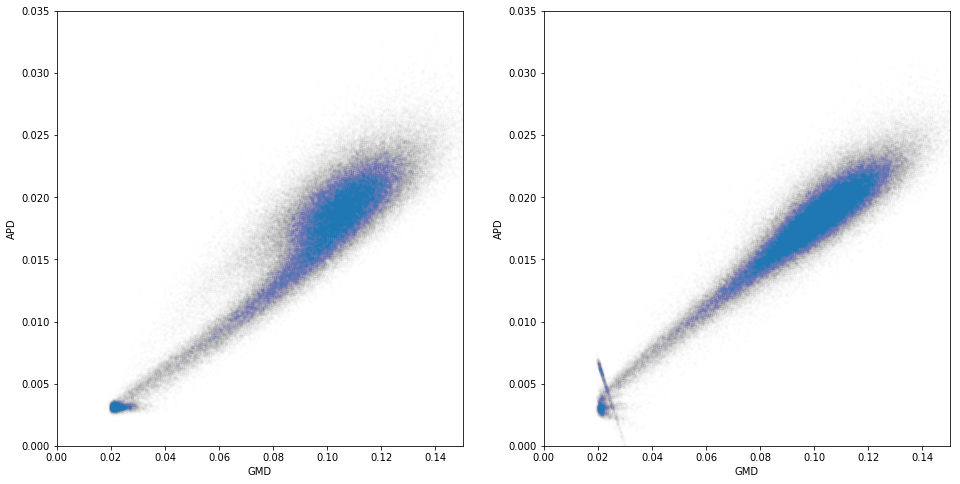

In [238]:
subplot(121)
plot(gmd_flux,apd_flux,'.',alpha=0.002)
xlim(0,0.15)
ylim(0,0.035)
ylabel('APD')
xlabel('GMD')
subplot(122)
plot(gmd_flux,apd_corrected,'.',alpha=0.002)
xlim(0,0.15)
ylim(0,0.035)
ylabel('APD')
xlabel('GMD')
show()

## pump probe time calculation

### determining range of delay stage

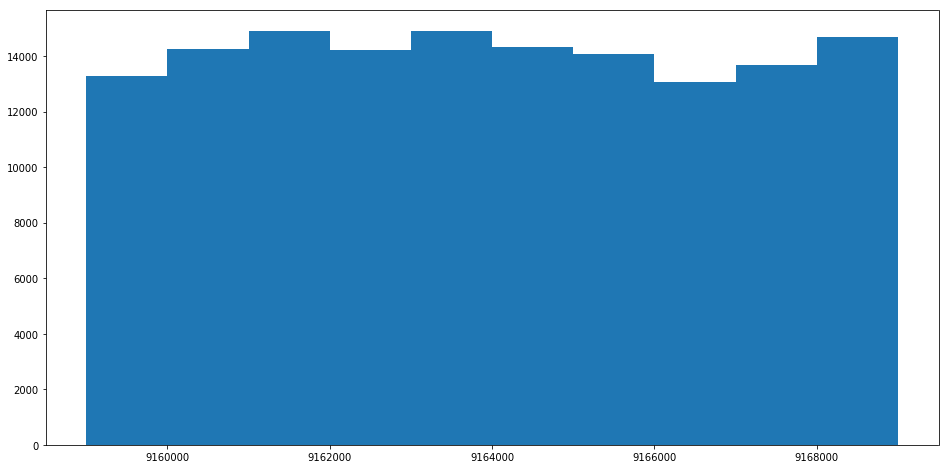

In [239]:
hist(delay_stage)
show()

In [ ]:
## using binned statistic to calculate time response

In [229]:
my_bins = arange(8.9e6,9.6e6,2e5/1000.0)
my_mask = gmd_flux > .04                          #masking out low fluence shots
z = delay_stage[my_mask]
y = apd_corrected[my_mask]
x = gmd_flux[my_mask]

In [265]:
pump_probe_trace = binned_statistic_dd(z,nan_to_num(y/x),bins =[my_bins],statistic=median).statistic
pump_probe_error = binned_statistic_dd(z,nan_to_num(y/x),bins =[my_bins],statistic=std).statistic
pump_probe_error /= binned_statistic_dd(z,nan_to_num(y/x),bins =[my_bins],statistic='count').statistic**0.5

In [266]:
#pump_probe_trace =  1.0*binned_statistic_dd(z,nan_to_num(y*x),bins = [my_bins],statistic=mean).statistic
#pump_probe_trace /= 1.0*binned_statistic_dd(z,nan_to_num(x*x),bins =[my_bins],statistic=mean).statistic

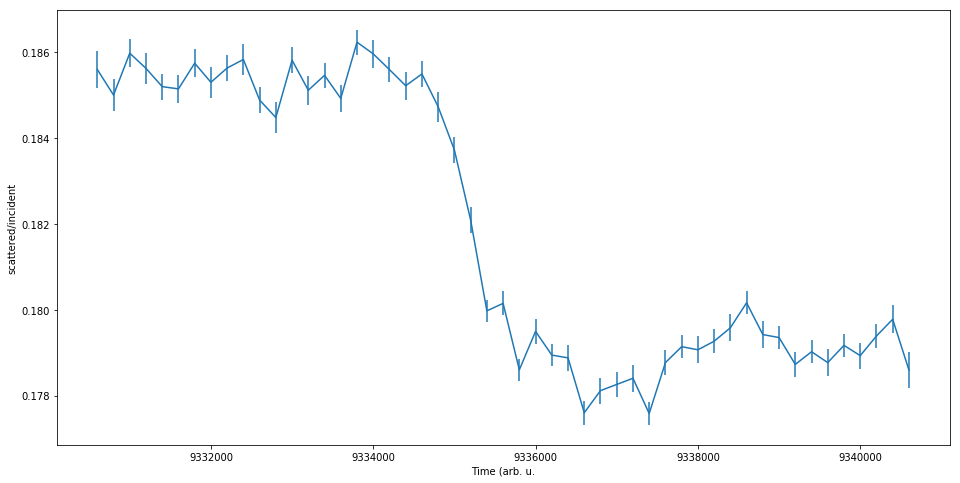

In [274]:
errorbar(my_bins[:-1][::-1],pump_probe_trace,yerr=nan_to_num(pump_probe_error))
ylabel("scattered/incident")
xlabel("Time (arb. u.")
show()